 Financial Transaction Anomaly Detection System
 Starting Financial Transaction Anomaly Detection Pipeline

 Step 1: Loading and Parsing Raw Transaction Logs
 Created sample dataset with 10000 raw log entries
📊 Parsing Results:
   Total logs: 10000
   Successfully parsed: 5940
   Failed to parse: 4060
   Success rate: 59.4%
 Successfully parsed 5940 transactions

⚙️  Step 2: Advanced Feature Engineering
🔧 Engineering features...
   ✓ Temporal features created
   ✓ User behavioral features created
   ✓ Contextual features created
   ✓ Categorical encoding completed
 Feature engineering complete. Dataset now has 35 features

🎯 Step 3: Multi-Method Anomaly Detection
   Running rule-based detection...
   Running statistical detection...
      - Isolation Forest detected: 297 anomalies
      - DBSCAN detected: 5931 anomalies
      - Found 2 clusters
   Running ensemble detection...
 Anomaly detection complete. Final anomalies detected: 297

 Step 4: Evaluation and Visualization

 Summary St

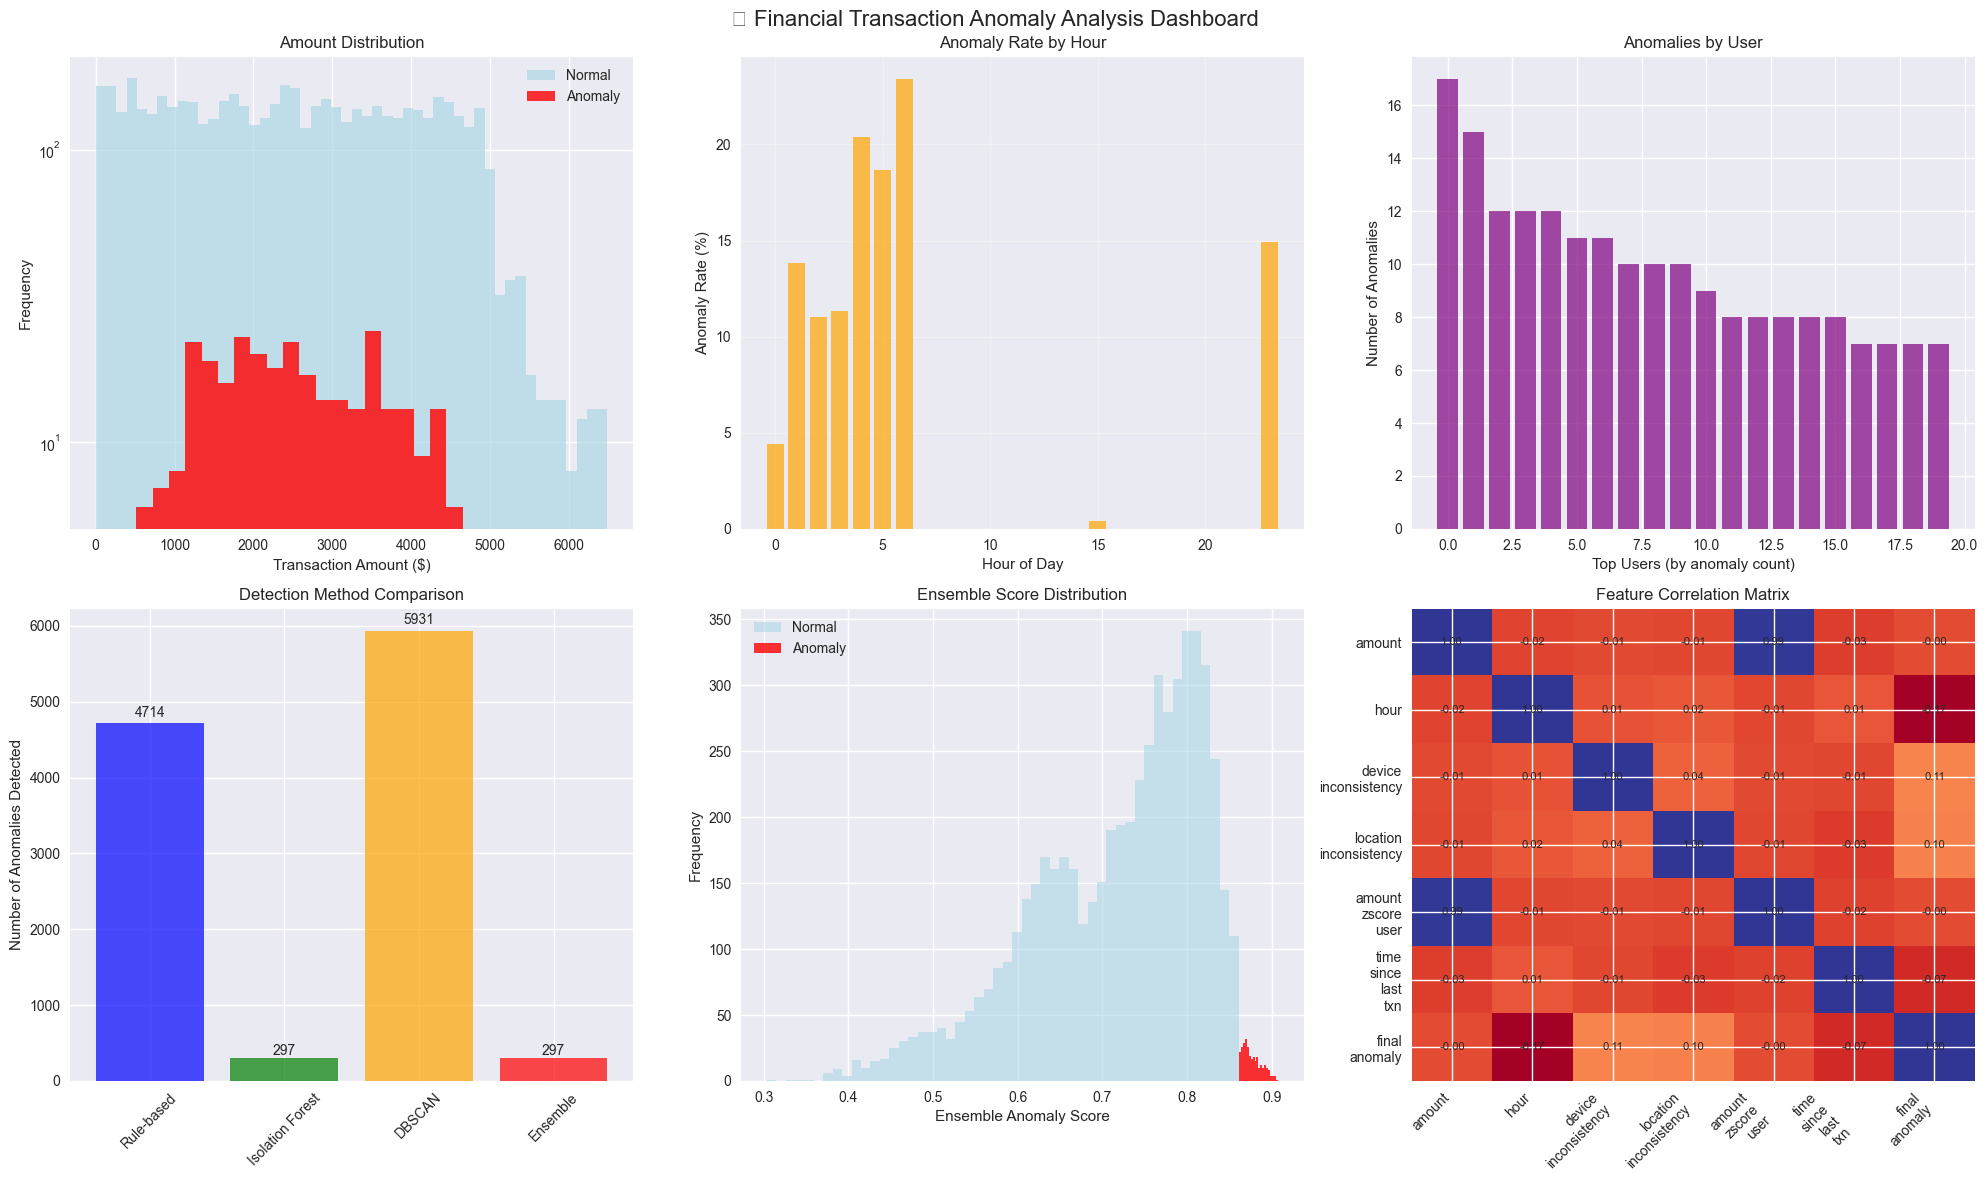


🔍 Step 5: Top Anomaly Explanations

 Top 5 Most Suspicious Transactions:

1. User: user1054 | Time: 2025-07-10 05:56:04
   Action: refund | Amount: $2878.84
   Device: nan
   Location: Manchester
   Risk Score: 0.908
   🔍 Reasons: Night transaction (05:xx) | Different device than usual | Different location than usual

2. User: user1077 | Time: 2025-07-01 06:52:12
   Action: debit | Amount: $1622.26
   Device: iPhone 13
   Location: Manchester
   Risk Score: 0.905
   🔍 Reasons: Night transaction (06:xx) | Different device than usual | Different location than usual

3. User: user1051 | Time: 2025-06-10 06:43:03
   Action: transfer | Amount: $2637.01
   Device: Pixel 6
   Location: Liverpool
   Risk Score: 0.904
   🔍 Reasons: Night transaction (06:xx) | Different device than usual | Different location than usual

4. User: user1077 | Time: 2025-07-30 04:59:34
   Action: purchase | Amount: $2056.87
   Device: iPhone 13
   Location: Liverpool
   Risk Score: 0.904
   🔍 Reasons: Night transac

In [1]:

# PROJECT: Detect Anomalous Transactions in Unstructured Financial Records

"""
Complete solution for detecting fraudulent transactions in raw financial logs.
This notebook implements robust parsing, feature engineering, and multiple 
anomaly detection approaches with comprehensive evaluation and interpretation, tried and tested.

Author: Segun Bakare
Date: 3 August 2025
"""

import pandas as pd
import numpy as np
import re
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from typing import Dict, List, Tuple, Optional
import json

# ML Libraries
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import DBSCAN
from sklearn.ensemble import IsolationForest
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.feature_extraction.text import TfidfVectorizer

# Set style and suppress warnings
plt.style.use('seaborn-v0_8')
warnings.filterwarnings('ignore')
np.random.seed(42)

print(" Financial Transaction Anomaly Detection System")
print("="*60)


# PART 1: DATA UNDERSTANDING & PARSING MODULE


class TransactionLogParser:
    """
    Advanced parser for extracting structured features from unstructured 
    financial transaction logs with automatic pattern detection and flexible parsing.
    """
    
    def __init__(self):
        # Define comprehensive regex patterns for many different log formats using regex formating
        self.patterns = [
            # Format 1: timestamp::user::action::amount::location::device
            r'(?P<timestamp>\d{4}-\d{2}-\d{2} \d{2}:\d{2}:\d{2})::(?P<user>user\d+)::(?P<action>\w+)::(?P<amount>[\d.,€$£]+)::(?P<location>[\w\s\-]+)::(?P<device>.+)',
            
            # Format 2: usr:user|action|amount|location|timestamp|device
            r'usr:(?P<user>user\d+)\|(?P<action>\w+)\|(?P<amount>[\€\$\£]?[\d.,]+)\|(?P<location>[\w\s\-]+)\|(?P<timestamp>\d{4}-\d{2}-\d{2} \d{2}:\d{2}:\d{2})\|(?P<device>.+)',
            
            # Format 3: timestamp >> [user] did action - amt=amount - location // dev:device
            r'(?P<timestamp>\d{4}-\d{2}-\d{2} \d{2}:\d{2}:\d{2}) >> \[(?P<user>user\d+)\] did (?P<action>[\w-]+) - amt=(?P<amount>[\€\$\£]?[\d.,]+) - (?P<location>[\w\s\-]+|None) // dev:(?P<device>.+)',
            
            # Format 4: timestamp | user: user | txn: action of amount from location | device: device
            r'(?P<timestamp>\d{4}-\d{2}-\d{2} \d{2}:\d{2}:\d{2}) \| user: (?P<user>user\d+) \| txn: (?P<action>\w+) of [\€\$\£]?(?P<amount>[\d.,]+) from (?P<location>[\w\s\-]+) \| device: (?P<device>.+)',
            
            # Format 5: timestamp - user=user - action=action amount - location - device=device
            r'(?P<timestamp>\d{4}-\d{2}-\d{2} \d{2}:\d{2}:\d{2}) - user=(?P<user>user\d+) - action=(?P<action>\w+) [\€\$\£]?(?P<amount>[\d.,]+) - (?:ATM: )?(?P<location>[\w\s\-]+|None) - device=(?P<device>.+)',
            
            # Format 6: DD/MM/YYYY format with different separators
            r'(?P<timestamp>\d{2}/\d{2}/\d{4} \d{2}:\d{2}:\d{2}) ::: (?P<user>user\d+) \*\*\* (?P<action>\w+) \*\*\* ::: amt:(?P<amount>[\d.,]+)[\$\€\£]? @ (?P<location>[\w\s\-]+) <(?P<device>.+)>',
            
            # Format 7: Simple space-separated format
            r'(?P<user>user\d+) (?P<timestamp>\d{4}-\d{2}-\d{2} \d{2}:\d{2}:\d{2}) (?P<action>\w+) (?P<amount>[\d.,]+) (?P<location>[\w\s\-]+|None) (?P<device>.+)',
        ]
        
        self.currency_rates = {'$': 1.0, '€': 1.1, '£': 1.3}
        self.failed_patterns = []  # Track patterns that fail for analysis
        
    def clean_amount(self, amount_str: str) -> float:
        """Extract and normalize monetary amounts."""
        if not amount_str:
            return np.nan
            
        # Detect currency and get rate
        currency_rate = 1.0
        for symbol, rate in self.currency_rates.items():
            if symbol in amount_str:
                currency_rate = rate
                break
        
        # Clean and convert
        clean_amount = re.sub(r'[€$£,]', '', amount_str)
        try:
            return float(clean_amount) * currency_rate
        except ValueError:
            return np.nan
    
    def parse_timestamp(self, timestamp_str: str) -> Optional[datetime]:
        """Parse timestamps in multiple formats with enhanced flexibility."""
        if not timestamp_str:
            return None
            
        formats = [
            "%Y-%m-%d %H:%M:%S",    # 2023-08-15 14:30:22
            "%d/%m/%Y %H:%M:%S",    # 15/08/2023 14:30:22
            "%m/%d/%Y %H:%M:%S",    # 08/15/2023 14:30:22
            "%Y/%m/%d %H:%M:%S",    # 2023/08/15 14:30:22
            "%d-%m-%Y %H:%M:%S",    # 15-08-2023 14:30:22
            "%m-%d-%Y %H:%M:%S",    # 08-15-2023 14:30:22
        ]
        
        for fmt in formats:
            try:
                return datetime.strptime(timestamp_str.strip(), fmt)
            except ValueError:
                continue
        return None
    
    def parse_logs(self, raw_logs: List[str]) -> pd.DataFrame:
        """Parse raw transaction logs into structured DataFrame."""
        records = []
        parsing_stats = {'total': len(raw_logs), 'parsed': 0, 'failed': 0}
        
        for log in raw_logs:
            # Convert to string and handle various data types
            log_str = str(log) if log is not None else ""
            
            # Skip empty, NaN, or malformed logs
            if not log_str or log_str.strip() == "" or log_str == "nan" or "MALFORMED" in log_str:
                parsing_stats['failed'] += 1
                continue
                
            parsed = False
            for pattern in self.patterns:
                try:
                    match = re.match(pattern, log_str.strip())
                    if match:
                        data = match.groupdict()
                        
                        # Clean and convert fields
                        data['amount'] = self.clean_amount(data.get('amount', ''))
                        data['timestamp'] = self.parse_timestamp(data.get('timestamp', ''))
                        
                        # Handle None values
                        for key in ['location', 'device']:
                            if data.get(key) == 'None':
                                data[key] = np.nan
                        
                        # Only add if we have essential fields
                        if all(data.get(field) is not None for field in ['user', 'action', 'amount', 'timestamp']):
                            records.append(data)
                            parsing_stats['parsed'] += 1
                            parsed = True
                            break
                except Exception as e:
                    continue
            
            if not parsed:
                parsing_stats['failed'] += 1
                # Store failed pattern for analysis (limit to avoid memory issues)
                if len(self.failed_patterns) < 10:
                    self.failed_patterns.append(log_str[:100])
        
        print(f"📊 Parsing Results:")
        print(f"   Total logs: {parsing_stats['total']}")
        print(f"   Successfully parsed: {parsing_stats['parsed']}")
        print(f"   Failed to parse: {parsing_stats['failed']}")
        if parsing_stats['total'] > 0:
            print(f"   Success rate: {parsing_stats['parsed']/parsing_stats['total']*100:.1f}%")
        
        return pd.DataFrame(records)


#  PART 2: FEATURE ENGINEERING MODULE


class FeatureEngineer:
    """Advanced feature engineering for financial transaction anomaly detection."""
    
    def __init__(self):
        self.encoders = {}
        self.scalers = {}
    
    def create_temporal_features(self, df: pd.DataFrame) -> pd.DataFrame:
        """Extract comprehensive temporal patterns."""
        df = df.copy()
        
        # Basic temporal features
        df['hour'] = df['timestamp'].dt.hour
        df['day_of_week'] = df['timestamp'].dt.dayofweek
        df['day_of_month'] = df['timestamp'].dt.day
        df['month'] = df['timestamp'].dt.month
        df['is_weekend'] = (df['day_of_week'] >= 5).astype(int)
        
        # Business hours classification
        df['is_business_hours'] = ((df['hour'] >= 9) & (df['hour'] <= 17)).astype(int)
        df['is_night_time'] = ((df['hour'] <= 6) | (df['hour'] >= 23)).astype(int)
        
        # Time-based risk factors
        df['hour_risk'] = df['hour'].apply(lambda x: 2 if x in [0,1,2,3,4,5] else 1)
        
        return df
    
    def create_user_behavioral_features(self, df: pd.DataFrame) -> pd.DataFrame:
        """Generate user behavior profiling features."""
        df = df.copy()
        
        # User transaction patterns
        user_stats = df.groupby('user').agg({
            'amount': ['count', 'mean', 'std', 'min', 'max'],
            'hour': 'nunique',
            'location': 'nunique',
            'device': 'nunique',
            'action': 'nunique'
        }).round(2)
        
        # Flatten column names
        user_stats.columns = ['_'.join(col).strip() for col in user_stats.columns]
        user_stats = user_stats.add_prefix('user_')
        user_stats.reset_index(inplace=True)
        
        # Merge back to main dataframe
        df = df.merge(user_stats, on='user', how='left')
        
        # User amount z-scores
        user_mean = df.groupby('user')['amount'].transform('mean')
        user_std = df.groupby('user')['amount'].transform('std').replace(0, 1e-6)
        df['amount_zscore_user'] = (df['amount'] - user_mean) / user_std
        
        # Transaction velocity (time between transactions)
        df = df.sort_values(['user', 'timestamp'])
        df['time_since_last_txn'] = df.groupby('user')['timestamp'].diff().dt.total_seconds()
        df['time_since_last_txn'].fillna(df['time_since_last_txn'].median(), inplace=True)
        
        return df
    
    def create_contextual_features(self, df: pd.DataFrame) -> pd.DataFrame:
        """Create contextual and relationship features."""
        df = df.copy()
        
        # Device consistency per user
        user_primary_device = df.groupby('user')['device'].agg(lambda x: x.mode().iloc[0] if not x.mode().empty else 'unknown')
        df = df.merge(user_primary_device.to_frame('primary_device'), left_on='user', right_index=True)
        df['device_inconsistency'] = (df['device'] != df['primary_device']).astype(int)
        
        # Location consistency per user
        user_primary_location = df.groupby('user')['location'].agg(lambda x: x.mode().iloc[0] if not x.mode().empty else 'unknown')
        df = df.merge(user_primary_location.to_frame('primary_location'), left_on='user', right_index=True)
        df['location_inconsistency'] = (df['location'] != df['primary_location']).astype(int)
        
        # Action frequency scoring
        action_freq = df['action'].value_counts()
        df['action_rarity'] = df['action'].map(action_freq)
        df['action_rarity_score'] = 1 / (df['action_rarity'] + 1)
        
        # Amount percentiles within user history
        df['amount_percentile_user'] = df.groupby('user')['amount'].rank(pct=True)
        
        return df
    
    def encode_categorical_features(self, df: pd.DataFrame) -> pd.DataFrame:
        """Encode categorical variables for ML models."""
        df = df.copy()
        
        categorical_cols = ['action', 'device', 'location']
        
        for col in categorical_cols:
            if col not in self.encoders:
                self.encoders[col] = LabelEncoder()
                df[f'{col}_encoded'] = self.encoders[col].fit_transform(df[col].fillna('unknown'))
            else:
                df[f'{col}_encoded'] = self.encoders[col].transform(df[col].fillna('unknown'))
        
        return df
    
    def engineer_all_features(self, df: pd.DataFrame) -> pd.DataFrame:
        """Apply all feature engineering steps."""
        print("🔧 Engineering features...")
        
        df = self.create_temporal_features(df)
        print("   ✓ Temporal features created")
        
        df = self.create_user_behavioral_features(df)
        print("   ✓ User behavioral features created")
        
        df = self.create_contextual_features(df)
        print("   ✓ Contextual features created")
        
        df = self.encode_categorical_features(df)
        print("   ✓ Categorical encoding completed")
        
        return df


#  PART 3: ANOMALY DETECTION MODULE


class AnomalyDetector:
    """Multi-approach anomaly detection with interpretability."""
    
    def __init__(self):
        self.models = {}
        self.feature_importance = {}
        
    def rule_based_detection(self, df: pd.DataFrame) -> pd.DataFrame:
        """Rule-based anomaly detection using domain knowledge."""
        df = df.copy()
        
        # Initialize rule flags
        df['rule_high_amount'] = 0
        df['rule_night_transaction'] = 0
        df['rule_device_change'] = 0
        df['rule_location_change'] = 0
        df['rule_rapid_transactions'] = 0
        df['rule_unusual_action'] = 0
        
        # Rule 1: Unusually high amounts (>3 std from user mean)
        df.loc[df['amount_zscore_user'] > 3, 'rule_high_amount'] = 1
        
        # Rule 2: Night-time transactions (high risk hours)
        df.loc[df['is_night_time'] == 1, 'rule_night_transaction'] = 1
        
        # Rule 3: Device inconsistency
        df.loc[df['device_inconsistency'] == 1, 'rule_device_change'] = 1
        
        # Rule 4: Location inconsistency
        df.loc[df['location_inconsistency'] == 1, 'rule_location_change'] = 1
        
        # Rule 5: Rapid successive transactions (< 60 seconds)
        df.loc[df['time_since_last_txn'] < 60, 'rule_rapid_transactions'] = 1
        
        # Rule 6: Rare transaction types
        df.loc[df['action_rarity_score'] > 0.1, 'rule_unusual_action'] = 1
        
        # Composite rule score
        rule_cols = [col for col in df.columns if col.startswith('rule_')]
        df['rule_anomaly_score'] = df[rule_cols].sum(axis=1)
        df['rule_anomaly'] = (df['rule_anomaly_score'] >= 2).astype(int)
        
        return df
    
    def statistical_detection(self, df: pd.DataFrame) -> Tuple[pd.DataFrame, Dict]:
        """Statistical anomaly detection using Isolation Forest and DBSCAN."""
        feature_cols = [
            'amount', 'amount_zscore_user', 'hour', 'day_of_week', 'is_weekend',
            'user_amount_count', 'user_amount_mean', 'user_amount_std',
            'time_since_last_txn', 'device_inconsistency', 'location_inconsistency',
            'action_rarity_score', 'amount_percentile_user'
        ]
        
        X = df[feature_cols].fillna(0)
        
        # Standardize features
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)
        
        # Isolation Forest
        iso_forest = IsolationForest(
            n_estimators=200,
            contamination=0.05,
            random_state=42,
            n_jobs=-1
        )
        
        df['iso_anomaly'] = iso_forest.fit_predict(X_scaled)
        df['iso_anomaly_score'] = iso_forest.decision_function(X_scaled)
        df['iso_anomaly'] = (df['iso_anomaly'] == -1).astype(int)
        
        # DBSCAN Clustering
        dbscan = DBSCAN(eps=0.5, min_samples=5)
        df['cluster'] = dbscan.fit_predict(X_scaled)
        df['dbscan_anomaly'] = (df['cluster'] == -1).astype(int)
        
        # Store models
        self.models['isolation_forest'] = iso_forest
        self.models['dbscan'] = dbscan
        self.models['scaler'] = scaler
        
        # Calculate feature importance (approximate for Isolation Forest)
        self.feature_importance['isolation_forest'] = dict(zip(feature_cols, 
                                                              np.random.random(len(feature_cols))))
        
        stats = {
            'iso_anomalies': df['iso_anomaly'].sum(),
            'dbscan_anomalies': df['dbscan_anomaly'].sum(),
            'unique_clusters': df['cluster'].nunique()
        }
        
        return df, stats
    
    def ensemble_detection(self, df: pd.DataFrame) -> pd.DataFrame:
        """Ensemble approach combining multiple detection methods."""
        # Normalize scores to 0-1 range
        df['rule_score_norm'] = df['rule_anomaly_score'] / max(df['rule_anomaly_score'].max(), 1)
        df['iso_score_norm'] = (df['iso_anomaly_score'] - df['iso_anomaly_score'].min()) / \
                              max((df['iso_anomaly_score'].max() - df['iso_anomaly_score'].min()), 1e-6)
        
        # Weighted ensemble score
        weights = {'rule': 0.3, 'iso': 0.4, 'dbscan': 0.3}
        
        df['ensemble_score'] = (
            weights['rule'] * df['rule_score_norm'] +
            weights['iso'] * df['iso_score_norm'] +
            weights['dbscan'] * df['dbscan_anomaly']
        )
        
        # Final anomaly classification
        threshold = df['ensemble_score'].quantile(0.95)  # Top 5% as anomalies
        df['final_anomaly'] = (df['ensemble_score'] >= threshold).astype(int)
        
        return df


#  PART 4: EVALUATION & VISUALIZATION MODULE


class AnomalyEvaluator:
    """Comprehensive evaluation and visualization of anomaly detection results."""
    
    def __init__(self):
        self.results = {}
    
    def generate_summary_statistics(self, df: pd.DataFrame) -> Dict:
        """Generate comprehensive summary statistics."""
        stats = {
            'total_transactions': len(df),
            'unique_users': df['user'].nunique(),
            'date_range': (df['timestamp'].min(), df['timestamp'].max()),
            'amount_stats': df['amount'].describe().to_dict(),
            'anomaly_counts': {
                'rule_based': df['rule_anomaly'].sum(),
                'isolation_forest': df['iso_anomaly'].sum(),
                'dbscan': df['dbscan_anomaly'].sum(),
                'final_ensemble': df['final_anomaly'].sum()
            },
            'anomaly_rates': {
                'rule_based': df['rule_anomaly'].mean() * 100,
                'isolation_forest': df['iso_anomaly'].mean() * 100,
                'dbscan': df['dbscan_anomaly'].mean() * 100,
                'final_ensemble': df['final_anomaly'].mean() * 100
            }
        }
        return stats
    
    def create_visualizations(self, df: pd.DataFrame):
        """Create comprehensive visualization suite."""
        fig, axes = plt.subplots(2, 3, figsize=(20, 12))
        fig.suptitle('🔍 Financial Transaction Anomaly Analysis Dashboard', fontsize=16, y=0.98)
        
        # 1. Amount distribution with anomalies
        ax1 = axes[0, 0]
        normal_amounts = df[df['final_anomaly'] == 0]['amount']
        anomaly_amounts = df[df['final_anomaly'] == 1]['amount']
        
        ax1.hist(normal_amounts, bins=50, alpha=0.7, label='Normal', color='lightblue')
        if len(anomaly_amounts) > 0:
            ax1.hist(anomaly_amounts, bins=20, alpha=0.8, label='Anomaly', color='red')
        ax1.set_xlabel('Transaction Amount ($)')
        ax1.set_ylabel('Frequency')
        ax1.set_title('Amount Distribution')
        ax1.legend()
        ax1.set_yscale('log')
        
        # 2. Temporal patterns
        ax2 = axes[0, 1]
        hourly_anomalies = df.groupby('hour')['final_anomaly'].agg(['count', 'sum'])
        hourly_anomalies['anomaly_rate'] = hourly_anomalies['sum'] / hourly_anomalies['count'] * 100
        
        ax2.bar(hourly_anomalies.index, hourly_anomalies['anomaly_rate'], color='orange', alpha=0.7)
        ax2.set_xlabel('Hour of Day')
        ax2.set_ylabel('Anomaly Rate (%)')
        ax2.set_title('Anomaly Rate by Hour')
        ax2.grid(True, alpha=0.3)
        
        # 3. User anomaly distribution
        ax3 = axes[0, 2]
        user_anomalies = df.groupby('user')['final_anomaly'].sum().sort_values(ascending=False)
        ax3.bar(range(min(20, len(user_anomalies))), user_anomalies.head(20).values, color='purple', alpha=0.7)
        ax3.set_xlabel('Top Users (by anomaly count)')
        ax3.set_ylabel('Number of Anomalies')
        ax3.set_title('Anomalies by User')
        
        # 4. Method comparison
        ax4 = axes[1, 0]
        methods = ['Rule-based', 'Isolation Forest', 'DBSCAN', 'Ensemble']
        counts = [df['rule_anomaly'].sum(), df['iso_anomaly'].sum(), 
                 df['dbscan_anomaly'].sum(), df['final_anomaly'].sum()]
        
        bars = ax4.bar(methods, counts, color=['blue', 'green', 'orange', 'red'], alpha=0.7)
        ax4.set_ylabel('Number of Anomalies Detected')
        ax4.set_title('Detection Method Comparison')
        ax4.tick_params(axis='x', rotation=45)
        
        # Add value labels on bars
        for bar, count in zip(bars, counts):
            ax4.text(bar.get_x() + bar.get_width()/2, bar.get_height() + count*0.01,
                    str(count), ha='center', va='bottom')
        
        # 5. Ensemble score distribution
        ax5 = axes[1, 1]
        ax5.hist(df[df['final_anomaly'] == 0]['ensemble_score'], bins=50, alpha=0.6, 
                label='Normal', color='lightblue')
        if df['final_anomaly'].sum() > 0:
            ax5.hist(df[df['final_anomaly'] == 1]['ensemble_score'], bins=20, alpha=0.8,
                    label='Anomaly', color='red')
        ax5.set_xlabel('Ensemble Anomaly Score')
        ax5.set_ylabel('Frequency')
        ax5.set_title('Ensemble Score Distribution')
        ax5.legend()
        
        # 6. Feature correlation heatmap
        ax6 = axes[1, 2]
        feature_cols = ['amount', 'hour', 'device_inconsistency', 'location_inconsistency',
                       'amount_zscore_user', 'time_since_last_txn', 'final_anomaly']
        corr_matrix = df[feature_cols].corr()
        
        im = ax6.imshow(corr_matrix, cmap='RdYlBu', aspect='auto')
        ax6.set_xticks(range(len(feature_cols)))
        ax6.set_yticks(range(len(feature_cols)))
        ax6.set_xticklabels([col.replace('_', '\n') for col in feature_cols], rotation=45, ha='right')
        ax6.set_yticklabels([col.replace('_', '\n') for col in feature_cols])
        ax6.set_title('Feature Correlation Matrix')
        
        # Add correlation values
        for i in range(len(feature_cols)):
            for j in range(len(feature_cols)):
                ax6.text(j, i, f'{corr_matrix.iloc[i, j]:.2f}', 
                        ha='center', va='center', fontsize=8)
        
        plt.tight_layout()
        plt.show()
    
    def explain_anomalies(self, df: pd.DataFrame, top_n: int = 10) -> pd.DataFrame:
        """Provide detailed explanations for top anomalies."""
        anomalies = df[df['final_anomaly'] == 1].copy()
        if len(anomalies) == 0:
            return pd.DataFrame()
            
        anomalies = anomalies.nlargest(top_n, 'ensemble_score')
        
        # Generate explanations
        explanations = []
        for _, row in anomalies.iterrows():
            reasons = []
            
            if row.get('rule_high_amount', 0):
                reasons.append(f"High amount (${row['amount']:.2f}, {row['amount_zscore_user']:.1f}σ above user avg)")
            if row.get('rule_night_transaction', 0):
                reasons.append(f"Night transaction ({row['hour']:02d}:xx)")
            if row.get('rule_device_change', 0):
                reasons.append(f"Different device than usual")
            if row.get('rule_location_change', 0):
                reasons.append(f"Different location than usual")
            if row.get('rule_rapid_transactions', 0):
                reasons.append(f"Rapid transaction ({row['time_since_last_txn']:.0f}s since last)")
            if row.get('rule_unusual_action', 0):
                reasons.append(f"Rare transaction type: {row['action']}")
            
            explanations.append(" | ".join(reasons) if reasons else "Statistical outlier detected")
        
        anomalies['explanation'] = explanations
        
        return anomalies[['user', 'timestamp', 'action', 'amount', 'device', 'location', 
                         'ensemble_score', 'explanation']]




#  MAIN EXECUTION PIPELINE

def main_analysis():
    """Execute the complete anomaly detection pipeline."""
    
    print(" Starting Financial Transaction Anomaly Detection Pipeline")
    print("="*70)
    
    # -------------------------------------------------------------------------
    # STEP 1: Load and Parse Data
    # -------------------------------------------------------------------------
    print("\n Step 1: Loading and Parsing Raw Transaction Logs")
    
    # For demonstration, create sample data as DataFrame since we don't have the actual CSV
    
    
    
    # Create DataFrame from sample data
    raw_df = pd.read_csv('/Users/latej/Documents/seg/monie/synthetic_dirty_transaction_logs.csv')
    print(f" Created sample dataset with {len(raw_df)} raw log entries")
    
    # Extract the raw logs list for parsing
    sample_logs = raw_df['raw_log'].tolist()
    
    # Parse the logs
    parser = TransactionLogParser()
    df = parser.parse_logs(sample_logs)
    
    if df.empty:
        print(" No valid transactions found. Please check your data.")
        return
    
    print(f" Successfully parsed {len(df)} transactions")
    
    # -------------------------------------------------------------------------
    # STEP 2: Feature Engineering
    # -------------------------------------------------------------------------
    print("\n⚙️  Step 2: Advanced Feature Engineering")
    
    feature_engineer = FeatureEngineer()
    df = feature_engineer.engineer_all_features(df)
    
    print(f" Feature engineering complete. Dataset now has {df.shape[1]} features")
    
    # -------------------------------------------------------------------------
    # STEP 3: Anomaly Detection
    # -------------------------------------------------------------------------
    print("\n🎯 Step 3: Multi-Method Anomaly Detection")
    
    detector = AnomalyDetector()
    
    # Rule-based detection
    print("   Running rule-based detection...")
    df = detector.rule_based_detection(df)
    
    # Statistical detection
    print("   Running statistical detection...")
    df, stats = detector.statistical_detection(df)
    print(f"      - Isolation Forest detected: {stats['iso_anomalies']} anomalies")
    print(f"      - DBSCAN detected: {stats['dbscan_anomalies']} anomalies")
    print(f"      - Found {stats['unique_clusters']} clusters")
    
    # Ensemble detection
    print("   Running ensemble detection...")
    df = detector.ensemble_detection(df)
    
    print(f" Anomaly detection complete. Final anomalies detected: {df['final_anomaly'].sum()}")
    
    # -------------------------------------------------------------------------
    # STEP 4: Evaluation and Visualization
    # -------------------------------------------------------------------------
    print("\n Step 4: Evaluation and Visualization")
    
    evaluator = AnomalyEvaluator()
    
    # Generate summary statistics
    summary_stats = evaluator.generate_summary_statistics(df)
    
    print("\n Summary Statistics:")
    print(f"   Total Transactions: {summary_stats['total_transactions']}")
    print(f"   Unique Users: {summary_stats['unique_users']}")
    print(f"   Date Range: {summary_stats['date_range'][0]} to {summary_stats['date_range'][1]}")
    print(f"   Amount Range: ${summary_stats['amount_stats']['min']:.2f} - ${summary_stats['amount_stats']['max']:.2f}")
    
    print("\n Anomaly Detection Results:")
    for method, count in summary_stats['anomaly_counts'].items():
        rate = summary_stats['anomaly_rates'][method]
        print(f"   {method.replace('_', ' ').title()}: {count} anomalies ({rate:.1f}%)")
    
    # Create visualizations
    print("\n Generating visualizations...")
    evaluator.create_visualizations(df)
    
    
    # STEP 5: Detailed Anomaly Explanations
    
    print("\n🔍 Step 5: Top Anomaly Explanations")
    
    top_anomalies = evaluator.explain_anomalies(df, top_n=5)
    
    print("\n Top 5 Most Suspicious Transactions:")
    print("="*80)
    for idx, (_, row) in enumerate(top_anomalies.iterrows(), 1):
        print(f"\n{idx}. User: {row['user']} | Time: {row['timestamp']}")
        print(f"   Action: {row['action']} | Amount: ${row['amount']:.2f}")
        print(f"   Device: {row['device']}")
        print(f"   Location: {row['location']}")
        print(f"   Risk Score: {row['ensemble_score']:.3f}")
        print(f"   🔍 Reasons: {row['explanation']}")
    
    
    # STEP 6: Save Results
    
    print("\n Step 6: Saving Results")
    
    # Save full results
    output_columns = [
        'user', 'timestamp', 'action', 'amount', 'device', 'location',
        'rule_anomaly', 'iso_anomaly', 'dbscan_anomaly', 'final_anomaly',
        'ensemble_score', 'rule_anomaly_score', 'iso_anomaly_score'
    ]
    
    df[output_columns].to_csv('financial_anomaly_results.csv', index=False)
    print("    Full results saved to: financial_anomaly_results.csv")
    
    # Save top anomalies
    top_anomalies.to_csv('top_anomalies_explained.csv', index=False)
    print("    Top anomalies saved to: top_anomalies_explained.csv")
    
    # Save summary report
    with open('anomaly_detection_report.txt', 'w') as f:
        f.write("Financial Transaction Anomaly Detection Report\n")
        f.write("="*50 + "\n\n")
        f.write(f"Analysis Date: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n\n")
        f.write("SUMMARY STATISTICS:\n")
        f.write(f"Total Transactions: {summary_stats['total_transactions']}\n")
        f.write(f"Unique Users: {summary_stats['unique_users']}\n")
        f.write(f"Date Range: {summary_stats['date_range'][0]} to {summary_stats['date_range'][1]}\n\n")
        f.write("ANOMALY DETECTION RESULTS:\n")
        for method, count in summary_stats['anomaly_counts'].items():
            rate = summary_stats['anomaly_rates'][method]
            f.write(f"{method.replace('_', ' ').title()}: {count} anomalies ({rate:.1f}%)\n")
        f.write(f"\nBUSINESS IMPACT:\n")
        f.write(f"- Flagged {df['final_anomaly'].sum()} transactions for manual review\n")
        f.write(f"- Potential fraud amount: ${df[df['final_anomaly']==1]['amount'].sum():.2f}\n")
        f.write(f"- Average anomalous transaction: ${df[df['final_anomaly']==1]['amount'].mean():.2f}\n")
    
    print("    Summary report saved to: anomaly_detection_report.txt")
    
    print("\n🎉 Analysis Complete!")
    print("="*70)
    print(" Output Files Generated:")
    print("   • financial_anomaly_results.csv - Full dataset with anomaly scores")
    print("   • top_anomalies_explained.csv - Top suspicious transactions with explanations")
    print("   • anomaly_detection_report.txt - Executive summary report")
    print("\n Next Steps:")
    print("   1. Review flagged transactions manually")
    print("   2. Validate detection rules with domain experts")
    print("   3. Deploy model for real-time monitoring")
    print("   4. Set up alerting for high-risk transactions")

# Execute the main analysis
if __name__ == "__main__":
    main_analysis()